# Environment Setup

In [1]:
from snowflake.snowpark.session import Session
from snowflake.snowpark.version import VERSION
import snowflake.snowpark as snp
import snowflake.snowpark.functions as F
import snowflake.snowpark.types as T
import snowflake.snowpark.window as W

import pandas as pd
import json
import seaborn as sns

from snowflake.ml.modeling.lightgbm import LGBMClassifier
from snowflake.ml.modeling.metrics import *

Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


## Create Snowpark Session

In [2]:
# Make a Snowpark Connection
# Edit the connection.json before creating the session object below
# Create Snowflake Session object

connection_parameters = json.load(open('connection.json'))
session = Session.builder.configs(connection_parameters).create()
session.custom_package_usage_config = {"enabled": True}
session.add_packages(["numpy==1.26.3"])

snowflake_environment = session.sql('SELECT current_user(), current_version()').collect()
snowpark_version = VERSION

# Current Environment Details
print('\nConnection Established with the following parameters:')
print('User                        : {}'.format(snowflake_environment[0][0]))
print('Role                        : {}'.format(session.get_current_role()))
print('Database                    : {}'.format(session.get_current_database()))
print('Schema                      : {}'.format(session.get_current_schema()))
print('Warehouse                   : {}'.format(session.get_current_warehouse()))
print('Snowflake version           : {}'.format(snowflake_environment[0][1]))
print('Snowpark for Python version : {}.{}.{}'.format(snowpark_version[0],snowpark_version[1],snowpark_version[2]))

Parameter custom_package_usage_config is experimental since 1.6.0. Do not use it in production. 
The following packages are not available in Snowflake: ['numpy==1.26.3'].
If you are adding package(s) unavailable in Snowflake, it is highly recommended that you include the 'cache_path' configuration parameter in order to reduce latency.
Package numpy(version 1.26.3) contains native code, switching to latest available version in Snowflake instead.



Connection Established with the following parameters:
User                        : JOHN
Role                        : "ACCOUNTADMIN"
Database                    : "SCORED_MODEL"
Schema                      : "SCORED_MODEL"
Warehouse                   : "QUERY_WH"
Snowflake version           : 8.0.0
Snowpark for Python version : 1.11.1


## Feature Engineering

This notebook is based on the worksheet found here (https://www.kaggle.com/code/ambrosm/amex-lightgbm-quickstart), with some modifications. The dataset has multiple values per customer ID, so we will undertake some feature engineering to find the mean, standard deviation, min, max and last values of each customer ID, so we have features and customer ID as a unique key.

In [3]:
#Create Snowpark df from shared data
training_df = session.table('"CC_DEFAULT_TRAINING_DATA"."DATA_SHARING_DEMO"."CC_DEFAULT_TRAINING_DATA"')

In [4]:
# Check number of rows (5,531,451 rows)
training_df.count()

5531451

In [5]:
# Check first 5 rows
training_df.show(5)

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

For the next section, we are going to perform feature engineering create three groups of features:
- Selected features averaged over all statements of a customer
- The minimum or maximum of selected features over all statements of a customer
- Selected features taken from the last statement of a customer

In [6]:
# The following cells create the average numerical values for selected features per customer
features_avg = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_50', 'D_51', 'D_53', 'D_54', 'D_55', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_65', 'D_66', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_86', 'D_91', 'D_92', 'D_94', 'D_96', 'D_103', 'D_104', 'D_108', 'D_112', 'D_113', 'D_114', 'D_115', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_129', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_14', 'R_15', 'R_16', 'R_17', 'R_20', 'R_21', 'R_22', 'R_24', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_9', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_18', 'S_22', 'S_23', 'S_25', 'S_26']

In [7]:
feat = [F.col(c) for c in features_avg]

In [8]:
exprs = {x: "avg" for x in features_avg}

In [9]:
df_avg = (training_df
          .groupBy('"customer_ID"')
          .agg(exprs)
          .rename({F.col(f"AVG({f})"): f"{f}_avg" for f in features_avg})
         )

In [10]:
df_avg.count()

458913

In [11]:
# The following cells create the minimum numerical values for selected features per customer
features_min = ['B_2', 'B_4', 'B_5', 'B_9', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_19', 'B_20', 'B_28', 'B_29', 'B_33', 'B_36', 'B_42', 'D_39', 'D_41', 'D_42', 'D_45', 'D_46', 'D_48', 'D_50', 'D_51', 'D_53', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_62', 'D_70', 'D_71', 'D_74', 'D_75', 'D_78', 'D_83', 'D_102', 'D_112', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_128', 'D_132', 'D_140', 'D_141', 'D_144', 'D_145', 'P_2', 'P_3', 'R_1', 'R_27', 'S_3', 'S_5', 'S_7', 'S_9', 'S_11', 'S_12', 'S_23', 'S_25']

In [12]:
exprs_min = {x: "min" for x in features_min}

In [13]:
df_min = (training_df
          .groupBy('"customer_ID"')
          .agg(exprs_min)
          .rename({F.col(f"MIN({f})"): f"{f}_min" for f in features_min})
         )

In [14]:
df_min.count()

458913

In [15]:
# The following cells create the maximum numerical values for selected features per customer
features_max = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_21', 'B_23', 'B_24', 'B_25', 'B_29', 'B_30', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_52', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_63', 'D_64', 'D_65', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_91', 'D_102', 'D_105', 'D_107', 'D_110', 'D_111', 'D_112', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_138', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_3', 'R_5', 'R_6', 'R_7', 'R_8', 'R_10', 'R_11', 'R_14', 'R_17', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_7', 'S_8', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']

In [16]:
exprs_max = {x: "max" for x in features_max}

In [17]:
df_max = (training_df
          .groupBy('"customer_ID"')
          .agg(exprs_max)
          .rename({F.col(f"MAX({f})"): f"{f}_max" for f in features_max})
         )

In [18]:
df_max.count()

458913

In [19]:
# The following cells create the last numerical values for selected features per customer, with S_2 being the date field.
features_last = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_86', 'D_91', 'D_96', 'D_105', 'D_106', 'D_112', 'D_114', 'D_119', 'D_120', 'D_121', 'D_122', 'D_124', 'D_125', 'D_126', 'D_127', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_138', 'D_140', 'D_141', 'D_142', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_19', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_11', 'S_12', 'S_13', 'S_16', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27', '"customer_ID"', '"target"']

In [20]:
w = snp.Window.partition_by('"customer_ID"').order_by(F.col('S_2').desc())

In [21]:
df_last = training_df.withColumn("rn", F.row_number().over(w)).filter("rn = 1").select(features_last)

In [22]:
df_last.count()

458913

In [23]:
# Now we join these dataframes on customer ID
feature_df = df_min.natural_join(df_avg)

In [24]:
feature_df = feature_df.natural_join(df_max)

In [25]:
feature_df = feature_df.natural_join(df_last)

In [26]:
feature_df.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [27]:
# Split the data into train and test sets
train_df, test_df = feature_df.random_split(weights=[0.9, 0.1], seed=0)

In [28]:
print((feature_df.count(), len(feature_df.columns)))
print((train_df.count(), len(train_df.columns)))
print((test_df.count(), len(test_df.columns)))

(458913, 471)
(413064, 471)
(45849, 471)


In [29]:
feature_cols = feature_df.columns

In [30]:
feature_cols = feature_df.columns
feature_cols.remove('"target"')
feature_cols.remove('"customer_ID"')
target_col = '"target"'

In [31]:
session.sql("USE DATABASE SCORED_MODEL").collect()

[Row(status='Statement executed successfully.')]

In [32]:
session.sql("USE SCHEMA SCORED_MODEL").collect()

[Row(status='Statement executed successfully.')]

In [33]:
session.sql("USE WAREHOUSE TRAINING_WH").collect()

[Row(status='Statement executed successfully.')]

The cell below trains the model with the Snowpark ML LGBM Classifier. We call the .fit function over the train_df we just created above

In [34]:
lgbmodel = LGBMClassifier(
    input_cols=feature_cols, 
    label_cols=target_col, 
    output_cols='PREDICTION'
    )
lgbmodel.fit(train_df)

/Users/tbuchhorn/opt/anaconda3/envs/pysnowpark1/lib/python3.10/site-packages/snowflake/ml/_internal/utils/snowpark_dataframe_utils.py:88: UserWarning: Warning: The Decimal(38, 6) data type is being automatically converted to DoubleType in the Snowpark DataFrame. This automatic conversion may lead to potential precision loss and rounding errors. If you wish to prevent this conversion, you should manually perform the necessary data type conversion.
  warnings.warn(
The version of package 'snowflake-snowpark-python' in the local environment is 1.11.1, which does not fit the criteria for the requirement 'snowflake-snowpark-python'. Your UDF might not work when the package version is different between the server and your local environment.
The following packages are not available in Snowflake: ['numpy==1.26.3'].
If you are adding package(s) unavailable in Snowflake, it is highly recommended that you include the 'cache_path' configuration parameter in order to reduce latency.
Package numpy(v

In [35]:
#Fix the fillna - maybe type float will help
scored_df = lgbmodel.predict(test_df.fillna(0.0))

Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "customer_ID", Type: StringType(16777216), Input Value: 0.0, Type: <class 'float'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "B_33_MIN", Type: LongType(), Input Value: 0.0, Type: <class 'float'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "B_36_MIN", Type: LongType(), Input Value: 0.0, Type: <class 'float'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "D_112_MIN", Type: LongType(), Input Value: 0.0, Type: <class 'float'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "D_128_MIN", Type: LongType(), Input Value: 0.0, Type: <class 'float'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "D_140_MIN", Type

Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "D_128_MAX", Type: LongType(), Input Value: 0.0, Type: <class 'float'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "D_135_MAX", Type: LongType(), Input Value: 0.0, Type: <class 'float'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "D_140_MAX", Type: LongType(), Input Value: 0.0, Type: <class 'float'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "R_17_MAX", Type: LongType(), Input Value: 0.0, Type: <class 'float'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "R_27_MAX", Type: LongType(), Input Value: 0.0, Type: <class 'float'>
Input value type doesn't match the target column data type, this replacement was skipped. Column Name: "B_8", Type: LongType(), Inpu

Acccuracy: 0.896399
Precision: 0.7755669019372278


The version of package 'numpy' in the local environment is 1.26.3, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.
DataFrame.flatten() is deprecated since 0.7.0. Use `DataFrame.join_table_function()` instead.


Recall: 0.8543424317617866


The version of package 'numpy' in the local environment is 1.26.3, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.


F1: 0.813051007556675


The version of package 'numpy' in the local environment is 1.26.3, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.
The version of package 'numpy' in the local environment is 1.26.3, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.


<Axes: >

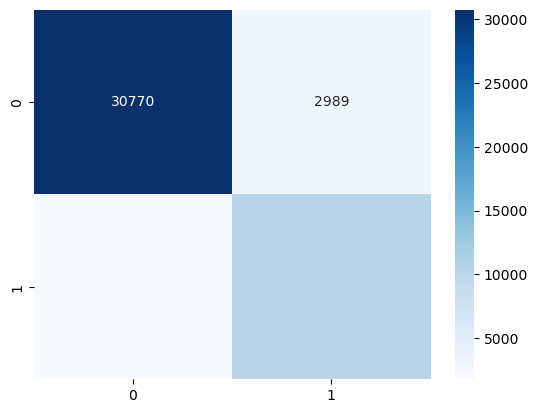

In [36]:
print('Acccuracy:', accuracy_score(df=scored_df, y_true_col_names='"target"', y_pred_col_names='PREDICTION'))
print('Precision:', precision_score(df=scored_df, y_true_col_names='"target"', y_pred_col_names='PREDICTION'))
print('Recall:', recall_score(df=scored_df, y_true_col_names='"target"', y_pred_col_names='PREDICTION'))
print('F1:', f1_score(df=scored_df, y_true_col_names='"target"', y_pred_col_names='PREDICTION'))

# Obtaining and plotting a simple confusion matrix
cf_matrix = confusion_matrix(df=scored_df, y_true_col_name='"target"', y_pred_col_name='PREDICTION')

sns.heatmap(cf_matrix, annot=True, fmt='.0f', cmap='Blues')

We are happy with the metrics of the model above, so we can persist the scored trained dataset (if we want to use it later), and proceed to registering the model

In [37]:
scored_df.write.save_as_table(table_name='CC_DEFAULT_RISK_TEST_SCORED', mode='overwrite')
session.table('CC_DEFAULT_RISK_TEST_SCORED').show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [ ]:
# Plot feature importance (only local)
feat_importance = pd.DataFrame(lgbmodel.feature_importances_,lgbmodel.feature_name_,columns=['FeatImportance'])
feat_importance.sort_values('FeatImportance').tail(10).plot.barh(y='FeatImportance', figsize=(5,15))

## Model Registration

Now we are happy with the mode we have trained, we can simply call the predict function on any new data that is sent from our client, the bank. Previously, we would have used UDFs to perform this task, but with ML on Snowpark, this has been greatly simplified. See more here: https://medium.com/snowflake/ml-on-snowflake-at-scale-with-snowpark-python-and-snowpark-ml-part-2-6491d72a9903

In [ ]:
#If you do not have a model registry, create one
# Create a registry and log the model
registry = model_registry.ModelRegistry(session=session, database_name="MODEL_REGISTRY", create_if_not_exists=True)

In [ ]:
from snowflake.ml.registry import model_registry

registry = model_registry.ModelRegistry(session=session
                                        , database_name="MODEL_REGISTRY")

model_id = registry.log_model(model=lgbmodel, model_name="cc_default_risk_model"
                              , model_version="1"
                              , tags={"stage": "testing"
                                 , "classifier_type": "lightgbm.LGBMClassifier"})

model = model_registry.ModelReference(registry=registry
                                      , model_name="cc_default_risk_model"
                                      , model_version="1")

#model.set_metric(metric_name="mean_squared_error", metric_value=mse)
#model.set_metric(metric_name="mean_absolute_error", metric_value=mab)
#model.set_metric(metric_name="r2_score", metric_value=r2)

In [ ]:
registry.set_metric(model_name="cc_default_risk_model", model_version="1", metric_name="accuracy_score", metric_value=accuracy_score)

In [ ]:
# Let's confirm it was added
registry.list_models().to_pandas()

In [ ]:
# Pick a deployment name and deploy
model_name = "cc_default_risk_model"
model_version = "1"
model_deployment_name = model_name + f"{model_version}" + "_UDF"

registry.deploy(model_name=model_name,
                model_version=model_version,
                deployment_name=model_deployment_name, 
                target_method="predict", 
                permanent=True, 
                options={"relax_version": True})

## Alternate Model Deployment
The alternative is to deploy via a vectorized UDF

In [38]:
# Create a stage for the model if it doesnt exist
session.sql("CREATE STAGE IF NOT EXISTS MODEL_ASSETS").collect()

[Row(status='MODEL_ASSETS already exists, statement succeeded.')]

In [39]:
# For this method, we convert the model to a local one, so we can stage it and deploy to Snowflake
lgbmodel_local = lgbmodel.to_lightgbm()

In [40]:
import joblib

# Let's save our model first
MODEL_FILE = 'model.joblib'
joblib.dump(lgbmodel_local, MODEL_FILE) # we are just pickling it locally first

# You can also save the pickled object into the stage we created earlier
session.file.put(MODEL_FILE, "@MODEL_ASSETS", overwrite=True)

[PutResult(source='model.joblib', target='model.joblib.gz', source_size=387599, target_size=171680, source_compression='NONE', target_compression='GZIP', status='UPLOADED', message='')]

In [42]:
import cachetools
from snowflake.snowpark.functions import udf
# Cache the model load to optimize inference
@cachetools.cached(cache={})
def load_model(filename):
    import joblib
    import sys
    import os

    IMPORT_DIRECTORY_NAME = "snowflake_import_directory"
    import_dir = sys._xoptions[IMPORT_DIRECTORY_NAME]

    if import_dir:
        with open(os.path.join(import_dir, filename), 'rb') as file:
            m = joblib.load(file)
            return m

# Register the UDF via decorator
@udf(name='batch_predict_cc_default', 
     session=session, 
     replace=True, 
     is_permanent=True, 
     stage_location='@MODEL_ASSETS',
     input_types=[F.FloatType()]*len(feature_cols),
     return_type=F.FloatType(),
     imports=['@MODEL_ASSETS/model.joblib.gz'],
     packages=['pandas','joblib','cachetools','lightgbm', 'numpy', 'scikit-learn'])
def batch_predict_cc_default(test_df: pd.DataFrame) -> pd.Series:
    # Need to name the columns because column names aren't passed in to this function
    test_df.columns = feature_cols
    model = load_model('model.joblib.gz')
    return model.predict(test_df) # This is using the XGBoost library's model.predict(), not Snowpark ML's

The version of package 'numpy' in the local environment is 1.26.3, which does not fit the criteria for the requirement 'numpy'. Your UDF might not work when the package version is different between the server and your local environment.


In [43]:
test_df_w_preds = test_df.with_column('PREDICTION', batch_predict_cc_default(*feature_cols))
test_df_w_preds.show()

----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [44]:
# Test for accuracy
print('Acccuracy:', accuracy_score(df=test_df_w_preds, y_true_col_names='"target"', y_pred_col_names='PREDICTION'))

Acccuracy: 0.901764


Now we have a UDF deployed in our Snowflake account called "batch_predict_cc_default" that we can use on incoming data.

In [55]:
# FEATURE ENGINEERING LOGIC
import snowflake.snowpark
from snowflake.snowpark.functions import sproc

session.add_packages('snowflake-snowpark-python')

def feature_transform(session: snowflake.snowpark.Session, raw_table: str, output_table: str) -> str:
    training_df = session.table(raw_table)
    # Feature engineer raw input
    #Average
    features_avg = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_50', 'D_51', 'D_53', 'D_54', 'D_55', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_65', 'D_66', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_75', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_86', 'D_91', 'D_92', 'D_94', 'D_96', 'D_103', 'D_104', 'D_108', 'D_112', 'D_113', 'D_114', 'D_115', 'D_117', 'D_118', 'D_119', 'D_120', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_129', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_14', 'R_15', 'R_16', 'R_17', 'R_20', 'R_21', 'R_22', 'R_24', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_9', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_18', 'S_22', 'S_23', 'S_25', 'S_26']
    feat = [F.col(c) for c in features_avg]
    exprs = {x: "avg" for x in features_avg}
    df_avg = (training_df
          .groupBy('"customer_ID"')
          .agg(exprs)
          .rename({F.col(f"AVG({f})"): f"{f}_avg" for f in features_avg})
         )
    
    # Minimum
    features_min = ['B_2', 'B_4', 'B_5', 'B_9', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_19', 'B_20', 'B_28', 'B_29', 'B_33', 'B_36', 'B_42', 'D_39', 'D_41', 'D_42', 'D_45', 'D_46', 'D_48', 'D_50', 'D_51', 'D_53', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_62', 'D_70', 'D_71', 'D_74', 'D_75', 'D_78', 'D_83', 'D_102', 'D_112', 'D_113', 'D_115', 'D_118', 'D_119', 'D_121', 'D_122', 'D_128', 'D_132', 'D_140', 'D_141', 'D_144', 'D_145', 'P_2', 'P_3', 'R_1', 'R_27', 'S_3', 'S_5', 'S_7', 'S_9', 'S_11', 'S_12', 'S_23', 'S_25']
    exprs_min = {x: "min" for x in features_min}
    df_min = (training_df
          .groupBy('"customer_ID"')
          .agg(exprs_min)
          .rename({F.col(f"MIN({f})"): f"{f}_min" for f in features_min})
         )
    
    # Maximum
    features_max = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_21', 'B_23', 'B_24', 'B_25', 'B_29', 'B_30', 'B_33', 'B_37', 'B_38', 'B_39', 'B_40', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_52', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_63', 'D_64', 'D_65', 'D_70', 'D_71', 'D_72', 'D_73', 'D_74', 'D_76', 'D_77', 'D_78', 'D_80', 'D_82', 'D_84', 'D_91', 'D_102', 'D_105', 'D_107', 'D_110', 'D_111', 'D_112', 'D_115', 'D_116', 'D_117', 'D_118', 'D_119', 'D_121', 'D_122', 'D_123', 'D_124', 'D_125', 'D_126', 'D_128', 'D_131', 'D_132', 'D_133', 'D_134', 'D_135', 'D_136', 'D_138', 'D_140', 'D_141', 'D_142', 'D_144', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_3', 'R_5', 'R_6', 'R_7', 'R_8', 'R_10', 'R_11', 'R_14', 'R_17', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_7', 'S_8', 'S_11', 'S_12', 'S_13', 'S_15', 'S_16', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27']
    exprs_max = {x: "max" for x in features_max}
    df_max = (training_df
          .groupBy('"customer_ID"')
          .agg(exprs_max)
          .rename({F.col(f"MAX({f})"): f"{f}_max" for f in features_max})
         )
    
    # Last
    features_last = ['B_1', 'B_2', 'B_3', 'B_4', 'B_5', 'B_6', 'B_7', 'B_8', 'B_9', 'B_10', 'B_11', 'B_12', 'B_13', 'B_14', 'B_15', 'B_16', 'B_17', 'B_18', 'B_19', 'B_20', 'B_21', 'B_22', 'B_23', 'B_24', 'B_25', 'B_26', 'B_28', 'B_29', 'B_30', 'B_32', 'B_33', 'B_36', 'B_37', 'B_38', 'B_39', 'B_40', 'B_41', 'B_42', 'D_39', 'D_41', 'D_42', 'D_43', 'D_44', 'D_45', 'D_46', 'D_47', 'D_48', 'D_49', 'D_50', 'D_51', 'D_52', 'D_53', 'D_54', 'D_55', 'D_56', 'D_58', 'D_59', 'D_60', 'D_61', 'D_62', 'D_63', 'D_64', 'D_65', 'D_69', 'D_70', 'D_71', 'D_72', 'D_73', 'D_75', 'D_76', 'D_77', 'D_78', 'D_79', 'D_80', 'D_81', 'D_82', 'D_83', 'D_86', 'D_91', 'D_96', 'D_105', 'D_106', 'D_112', 'D_114', 'D_119', 'D_120', 'D_121', 'D_122', 'D_124', 'D_125', 'D_126', 'D_127', 'D_130', 'D_131', 'D_132', 'D_133', 'D_134', 'D_138', 'D_140', 'D_141', 'D_142', 'D_145', 'P_2', 'P_3', 'P_4', 'R_1', 'R_2', 'R_3', 'R_4', 'R_5', 'R_6', 'R_7', 'R_8', 'R_9', 'R_10', 'R_11', 'R_12', 'R_13', 'R_14', 'R_15', 'R_19', 'R_20', 'R_26', 'R_27', 'S_3', 'S_5', 'S_6', 'S_7', 'S_8', 'S_9', 'S_11', 'S_12', 'S_13', 'S_16', 'S_19', 'S_20', 'S_22', 'S_23', 'S_24', 'S_25', 'S_26', 'S_27', '"customer_ID"']
    w = snp.Window.partition_by('"customer_ID"').order_by(F.col('S_2').desc())
    df_last = training_df.withColumn("rn", F.row_number().over(w)).filter("rn = 1").select(features_last)
    
    # Join
    feature_df = df_min.natural_join(df_avg)
    feature_df = feature_df.natural_join(df_max)
    feature_df = feature_df.natural_join(df_last)
    
    feature_df.write.save_as_table(output_table)
    
    return "Success"

The version of package 'snowflake-snowpark-python' in the local environment is 1.11.1, which does not fit the criteria for the requirement 'snowflake-snowpark-python'. Your UDF might not work when the package version is different between the server and your local environment.


In [56]:
session.sproc.register(feature_transform, name="feature_transform", replace=True)

In [57]:
session.call("feature_transform", "CC_DEFAULT_TRAINING_DATA", "TRANSFORMED_TABLE")

'Success'